# Use Cases and Examples for maxent_disaggregation

The `maxent_disaggregation` package enables statistically sound disaggregation of aggregate data with uncertainty propagation. When disaggregating data (splitting a total into components), the components are naturally correlated. These correlations must be properly accounted for in uncertainty analysis to avoid mis-estimating uncertainty in downstream calculations.

This notebook demonstrates how to use `maxent_disaggregation` through a simple example in Industrial Ecology.

## Example: Carbon Footprint of Steel in Vehicle Manufacturing

### Problem Statement

An Industrial Ecology researcher has data on total steel consumption for vehicle manufacturing but needs to disaggregate this figure by vehicle type (ICE, BEV, and HBEV) based on production volume proxies. A second researcher will use these disaggregated figures for Life Cycle Assessment (LCA).

![Figure 1: A diagram of the example](../data/example_steel.png)

Properly accounting for correlations between the disaggregated values is critical for accurate uncertainty estimation in the LCA.

### Available Information

The first researcher has:

1. A best estimate for total steel consumption: 100 tonnes/year
2. An uncertainty estimate for that total: standard deviation of 3 tonnes/year
3. A natural lower bound of 0 (no negative consumption)
4. Proxy-based estimates of shares by vehicle type: ICE (80%), BEV (19%), HBEV (1%)

### Generating Correlated Samples with maxent_disaggregation

With the function `maxent_disagg` from the `maxent_disaggregation` package we can generate samples from distributions that use all the available information above, and respect the total mass balance, and hence the statistical correlations between the samples of the individual components (vehicle types).

In [1]:
#  First import necessary libraries
import numpy as np
from maxent_disaggregation import maxent_disagg, plot_samples_hist, plot_covariances
import seaborn as sns


# Set parameters
n_samples = 10000   # Number of samples to generate
mean_aggregate = 100  # Best estimate for total
sd_aggregate = 3     # Standard deviation for total
min_aggregate = 0  # Minimum value for total
shares = [0.8, 0.19, 0.01]  # Proxy-based estimates of shares
vehicle_types = ["ICE", "BEV", "HBEV"]

In [2]:
# Generate correlated samples
samples, _ = maxent_disagg(
    n=n_samples,  # Number of samples to generate
    mean_0=mean_aggregate,  # Mean of the aggregate total
    sd_0=sd_aggregate,  # Standard deviation of the aggregate total
    min_0=min_aggregate,  # Lower bound
    shares=shares,  # Best estimates of the shares
    log=True,  # Use log-normal distribution for sampling
)


The `log = TRUE` parameter means we're assuming a log-normal distribution for the aggregate, which is appropriate for quantities that cannot be negative and may be right-skewed. Setting `log = FALSE` would assume a truncated normal distribution (because of `min = 0`). 

The result is a matrix with three columns (one per vehicle type) and 1,000 rows:

In [3]:
print(samples.shape)

(10000, 3)


### Visualizing the Distribution of Each Component

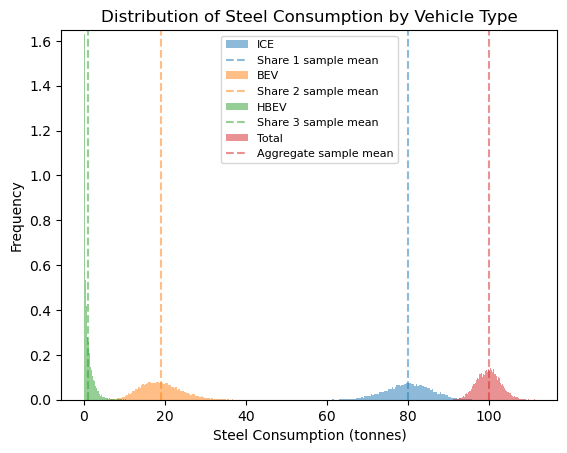

In [8]:
# Plot histograms for each vehicle type and the total
plot_samples_hist(
    samples=samples,
    legend_labels=vehicle_types + ['Total'],
    xlabel="Steel Consumption (tonnes)",
    ylabel="Frequency",
    title="Distribution of Steel Consumption by Vehicle Type",
    # ylim= (0, 0.8),  # Uncomment to set y-axis limits, note that this is merely a truncation of the axis and does not change the data
    save=False,
    filename=None
)

### Validating the Samples

Let's verify that our samples are consistent with our input information:



In [5]:
# Check if the total matches our specified mean and SD
sample_total = samples.sum(axis=1,keepdims=True)
print("Mean of the sampled total:", sample_total.mean(), "Input total mean:", mean_aggregate)
print("SD of the sampled total:", sample_total.std(), "Input total SD:", sd_aggregate)

# Check if shares match our specified values
sample_shares = np.divide(samples,sample_total)
print("Means of the sampled shares:", sample_shares.mean(axis=0), "Input shares:", np.array(shares))


Mean of the sampled total: 99.94996328899742 Input total mean: 100
SD of the sampled total: 2.9917366759292428 Input total SD: 3
Means of the sampled shares: [0.80082639 0.18918394 0.00998967] Input shares: [0.8  0.19 0.01]


### Understanding Correlations in the Sample

Because the components must sum to the total, they are naturally correlated:


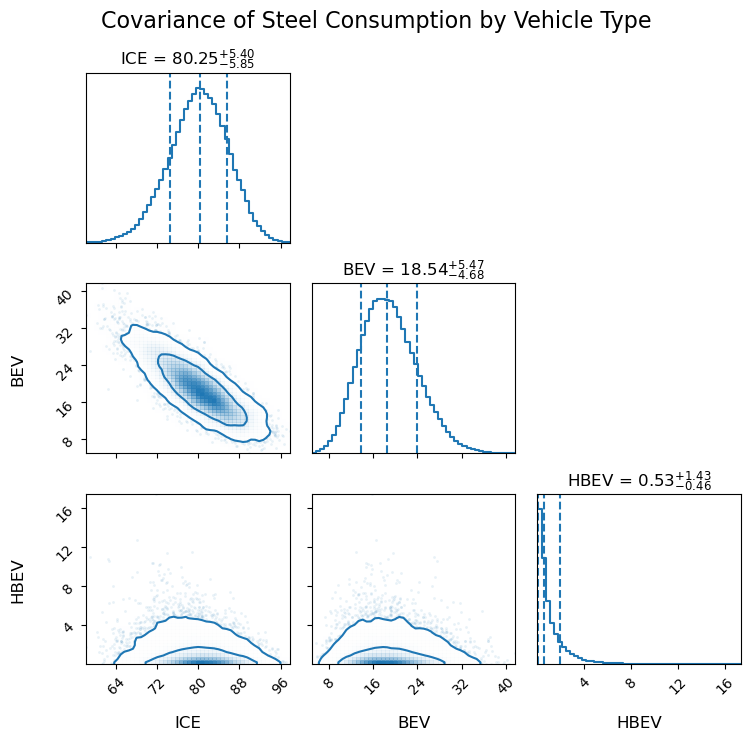

In [6]:
plot_covariances(samples=samples,labels=vehicle_types, title="Covariance of Steel Consumption by Vehicle Type")

The sign and magnitude of correlations depend on the relative uncertainties of the aggregate and shares. With moderate uncertainty in the total (CV = 3%) and high uncertainty in the shares (default Maximum Entropy behavior, see `dirichlet_max_ent` for more details), we observe negative correlations between components.

If we increase uncertainty in the total while constraining the shares more tightly:

/Users/ajakobs/Documents/code_projects/maxent_disaggregation/maxent_disaggregation/shares.py:438: UserWarning: The generated samples for the shares have a standard deviation that is more than 20.0% different from the specified sd's. Please note that the specified sd's might be incompetibale with the other constraints. Please check your inputs. To surpress this warning you can set a higher threshold_sd.
  warnings.warn(


Sds above threshold: [0.71993867 0.2900075 ],             sds: [0.008  0.0001], sample_sd: [0.00224049 0.000129  ],             indices: [0 2]


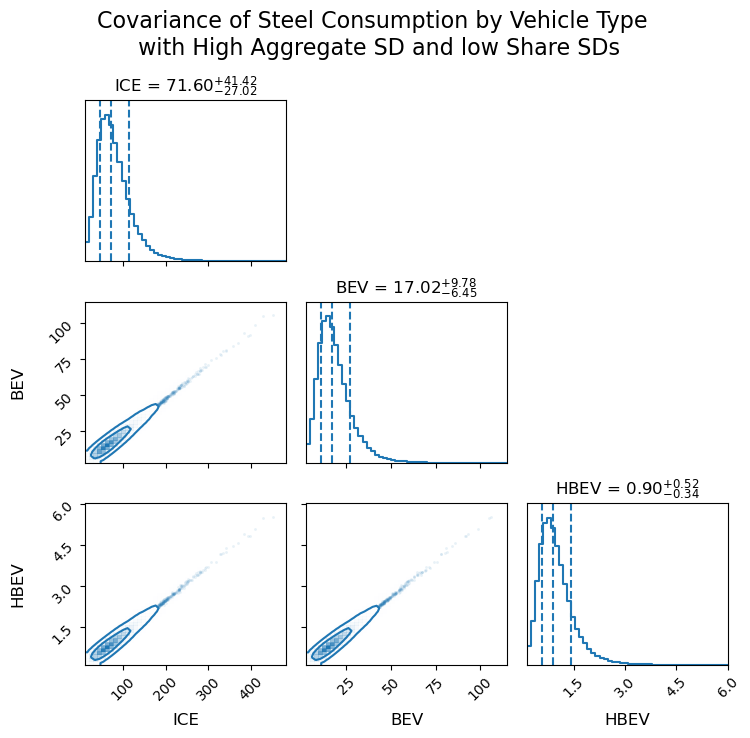

In [7]:
# Generate correlated samples
samples_2, _ = maxent_disagg(
    n=n_samples,  # Number of samples to generate
    mean_0=mean_aggregate,  # Mean of the aggregate total
    sd_0=50,  # High standard deviation of the aggregate total
    min_0=min_aggregate,  # Lower bound
    shares=shares,  # Best estimates of the shares
    sds=[0.008, 0.0019, 0.0001],  # Very small standard deviations for each share
    log=True,  # Use log-normal distribution for sampling
)

plot_covariances(samples=samples_2,
                 labels=vehicle_types, 
                 title="Covariance of Steel Consumption by Vehicle Type \n with High Aggregate SD and low Share SDs")

With high uncertainty in the total and low uncertainty in the shares, correlations become positive.


### Downstream Analysis: LCA of Carbon Footprint

Let's examine how these correlations impact a downstream LCA calculation. We will look at two cases: 1) where the full correlated samples are used in the the down stream analysis (model 2), and 2) where only the summary statistics are communicated from model 1 to model 2.


For simplicity we assume a single emission factor of 2.5 tonnes CO₂ per tonne of steel.


In [11]:
# Set emission factor
emission_factor_steel = 2.5

#### Approach 1: Using Full Samples (With Correlations)

Here we assume that researcher 1 has shared the full samples of their model and that these are used by researcher 2:

In [33]:
# Calculate emissions using correlated samples
sample_emissions_full = samples * emission_factor_steel
total_emissions_full = sample_emissions_full.sum(axis=1)

print("Total emissions using the full correlated samples:")
print("Mean emissions:", total_emissions_full.mean(), "tonnes CO₂")
print("SD emissions:", total_emissions_full.std(), "tonnes CO₂")
print("CV emissions:", total_emissions_full.std() / total_emissions_full.mean())

Total emissions using the full correlated samples:
Mean emissions: 249.87490822249353 tonnes CO₂
SD emissions: 7.479341689823109 tonnes CO₂
CV emissions: 0.029932343919715842


### Comparing Results with Independent Sampling

Here we assume that researcher 1 has only shared the summary statistics such as the mean and standard deviation of each sample:


In [16]:
from scipy.stats import truncnorm

In [29]:
means = samples.mean(axis=0)
standard_deviations = samples.std(axis=0)

# Independent sampling ignoring correlations using truncated normal distribution (lower bound at 0)
independent_samples = (truncnorm.rvs(
    loc=means, 
    scale=standard_deviations,
    a=(0 - means) / standard_deviations,  # Lower truncation
    b=(np.inf - means) / standard_deviations,  # Upper truncation
    size=(n_samples, len(vehicle_types))
))

# Calculate emissions using independent samples
sample_emissions_independent = independent_samples * emission_factor_steel
total_emissions_independent = sample_emissions_independent.sum(axis=1)

print("Total emissions using the uncorrelated sampling from summary statistics:")
print("Mean emissions (independent):", total_emissions_independent.mean(), "tonnes CO₂")
print("SD emissions (independent):", total_emissions_independent.std(), "tonnes CO₂")
print("CV emissions (independent):", total_emissions_independent.std() / total_emissions_independent.mean())

Total emissions using the uncorrelated sampling from summary statistics:
Mean emissions (independent): 251.1662912254688 tonnes CO₂
SD emissions (independent): 19.448661410084757 tonnes CO₂
CV emissions (independent): 0.07743340603228456


### Comparing Distributions

Let's compare the uncertainty distributions from both approaches:


In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

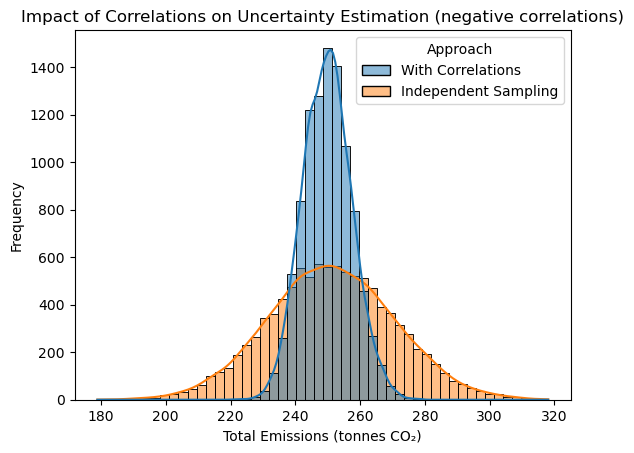

In [32]:
# Combine results for comparison
comparison_df = pd.DataFrame({
    "Emissions": np.concatenate([total_emissions_full, total_emissions_independent]),
    "Approach": ["With Correlations"] * len(total_emissions_full) + ["Independent Sampling"] * len(total_emissions_independent)
})

# Plot comparison
sns.histplot(data=comparison_df, x="Emissions", hue="Approach", kde=True, bins=50, alpha=0.5)
plt.xlabel("Total Emissions (tonnes CO₂)")
plt.ylabel("Frequency")
plt.title("Impact of Correlations on Uncertainty Estimation (negative correlations)");

We see that in the case of negative correlations we can overestimate the uncertainty by ignoring the correlations. 
Now let's see if we use the experiment with postive correlations:

Total emissions using the full correlated samples:
Mean emissions: 249.33440987992302 tonnes CO₂
SD emissions: 125.92011695537671 tonnes CO₂
CV emissions: 0.5050250264936099
Total emissions using the uncorrelated sampling from summary statistics:
Mean emissions (independent): 250.67295092686 tonnes CO₂
SD emissions (independent): 19.13197081391138 tonnes CO₂
CV emissions (independent): 0.07632243823344786


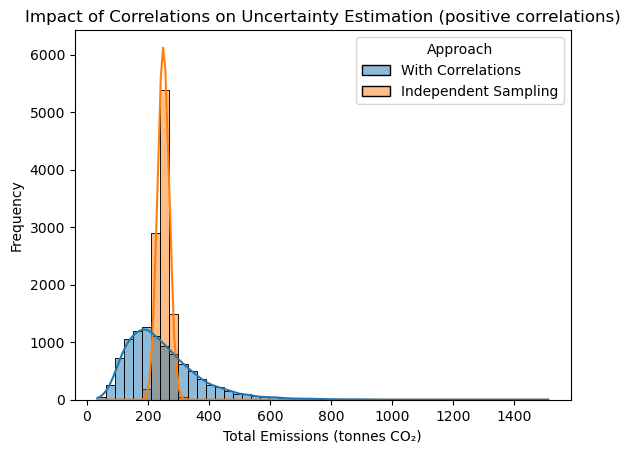

In [34]:
# Calculate emissions using correlated samples
sample_emissions_full = samples_2 * emission_factor_steel
total_emissions_full = sample_emissions_full.sum(axis=1)

print("Total emissions using the full correlated samples:")
print("Mean emissions:", total_emissions_full.mean(), "tonnes CO₂")
print("SD emissions:", total_emissions_full.std(), "tonnes CO₂")
print("CV emissions:", total_emissions_full.std() / total_emissions_full.mean())

means = samples_2.mean(axis=0)
standard_deviations_2 = samples.std(axis=0)

# Independent sampling ignoring correlations using truncated normal distribution (lower bound at 0)
independent_samples = (truncnorm.rvs(
    loc=means, 
    scale=standard_deviations,
    a=(0 - means) / standard_deviations,  # Lower truncation
    b=(np.inf - means) / standard_deviations,  # Upper truncation
    size=(n_samples, len(vehicle_types))
))

# Calculate emissions using independent samples
sample_emissions_independent = independent_samples * emission_factor_steel
total_emissions_independent = sample_emissions_independent.sum(axis=1)

print("Total emissions using the uncorrelated sampling from summary statistics:")
print("Mean emissions (independent):", total_emissions_independent.mean(), "tonnes CO₂")
print("SD emissions (independent):", total_emissions_independent.std(), "tonnes CO₂")
print("CV emissions (independent):", total_emissions_independent.std() / total_emissions_independent.mean())


# Combine results for comparison
comparison_df = pd.DataFrame({
    "Emissions": np.concatenate([total_emissions_full, total_emissions_independent]),
    "Approach": ["With Correlations"] * len(total_emissions_full) + ["Independent Sampling"] * len(total_emissions_independent)
})

# Plot comparison
sns.histplot(data=comparison_df, x="Emissions", hue="Approach", kde=True, bins=50, alpha=0.5)
plt.xlabel("Total Emissions (tonnes CO₂)")
plt.ylabel("Frequency")
plt.title("Impact of Correlations on Uncertainty Estimation (positive correlations)");

Ignoring positive correlations can lead to underestimation uncertainty in the final result.


## Conclusion

The above examples show why considering proper uncertainty propagation including correlation is important in the case of data disaggregation. Ignoring correlations can lead to **over-/under-estimation of uncertainty**! 
The `maxent_disaggregation` package provides a simple interface for generating statistical samples of disaggregated data while properly accounting for correlations, which is crucial for accurate uncertainty propagation in subsequent analyses.